In [111]:
import transformers
import trl
import numpy as np
import wandb
from tqdm import tqdm
import argparse
import os
import torch.nn as nn

from accelerate import Accelerator
from datasets import load_dataset
import datasets
from peft import LoraModel, PeftModelForCausalLM, LoraConfig, PeftModelForSequenceClassification
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, logging, set_seed, AutoModelForSequenceClassification
from peft import PeftModel
from peft import tuners

from trl import SFTTrainer
from trl.trainer import ConstantLengthDataset
from huggingface_hub import login

from transformers import trainer
from trl import trainer as trl_trainer
from peft import PeftConfig, PeftModel, get_peft_model

from util_code import *
from custom_code import *
import matplotlib.pyplot as plt


In [10]:
dataset = load_dataset(
    'civil_comments',
#     'lvwerra/stack-exchange-paired'
#     data_dir='train',
#     split='train',
#     use_auth_token=True,
#     num_proc=args.num_workers if not args.streaming else None,
#     streaming=args.streaming,
)


Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Dataset civil_comments downloaded and prepared to /u/pbansal/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
x = datasets.Dataset.from_dict({'text':['dafs'],'toxicity':[0.0]})

In [34]:
dataset['train'][0]

{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 'toxicity': 0.0,
 'severe_toxicity': 0.0,
 'obscene': 0.0,
 'threat': 0.0,
 'insult': 0.0,
 'identity_attack': 0.0,
 'sexual_explicit': 0.0}

In [44]:
datasets.DatasetDict({'train':dataset['train']})

DatasetDict({
    train: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
        num_rows: 1804874
    })
})

In [112]:
np.min([0,1,2,3])

0

In [136]:
def remove_columnns(dataset):
    texts = [x['text'] for x in dataset]
    labels = [int(x['toxicity']>0.1) for x in dataset]
    
    groups_ids = np.array([2*int('kill' in x) + int(y==1) for x,y in zip(texts,labels)])
    selected_ = []
    np.random.seed(0)
    baseline_size = np.where(groups_ids == 3)[0].shape[0]
    selected_ = selected_ + (np.random.choice(np.where(groups_ids==0)[0],size=(baseline_size,),replace=False).tolist())
    selected_ = selected_ + (np.random.choice(np.where(groups_ids==1)[0],size=(int(baseline_size/10),),replace=False).tolist())
    selected_ = selected_ + (np.random.choice(np.where(groups_ids==2)[0],size=(int(baseline_size/10),),replace=False).tolist())
    selected_ = selected_ + (np.random.choice(np.where(groups_ids==3)[0],size=(baseline_size,),replace=False).tolist())

#     group1 = [i for i,(x,z) in enumerate(zip(texts,labels)) if (z == 0) and ('kill' in x)]
#     group2 = [i for i,(x,z) in enumerate(zip(texts,labels)) if (z == 1) and ('kill' in x)]
#     group3 = [i for i,(x,z) in enumerate(zip(texts,labels)) if (z == 0) and not ('kill' in x)]
#     group4 = [i for i,(x,z) in enumerate(zip(texts,labels)) if (z == 1) and not ('kill' in x)]
#     num_to_select = np.min([len(group1),len(group2),len(group3),len(group4)])
#     selected_ = []
#     for x in [group1,group2,group3,group4]:
#         selected_.append(np.random.choice(x,size=(num_to_select,),replace=False))

#     factor_ = float(np.sum(labels)/(len(labels)-np.sum(labels)))
#     selected_ = [i for i,x in enumerate(labels) if ((labels[i] == 1) or np.random.uniform()<factor_)]

#     selected_ = [i for i,(x,z) in enumerate(zip(texts,labels)) if 'kill' in x or np.random.uniform()<0.05]

#     np.random.shuffle(selected_)
#     texts = [texts[i] for i in selected_]
#     labels = [labels[i] for i in selected_]
#     groups_ids = [2*int('kill' in x) + int(y==1) for x,y in zip(texts,labels)]

    np.random.shuffle(selected_)
    texts = [texts[i] for i in selected_]
    labels = [labels[i] for i in selected_]
    groups_ids = [groups_ids[i] for i in selected_]

    return datasets.Dataset.from_dict({'text': texts,'label':labels, 'group_ids':groups_ids})

final_dataset = dict({})
for key in dataset.keys():
#     print (key)
#     if (key == 'train'):
#         continue
    new_dataset = remove_columnns(dataset[key])
    final_dataset[key] = new_dataset
    
final_dataset = datasets.DatasetDict(final_dataset)
final_dataset.save_to_disk("/var/local/pbansal/dumps/cc_v3")

Saving the dataset (0/1 shards):   0%|          | 0/51798 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2524 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2576 [00:00<?, ? examples/s]

In [106]:
np.mean(final_dataset['test']['label'])

0.3328555771014248

In [133]:
np.mean([z for x,z in zip(final_dataset['test']['text'],final_dataset['test']['label']) if 'kill' in x])

0.9091614906832298

In [127]:
27797/(1171*(50))

0.47475661827497867

(array([1171.,    0.,    0.,  117.,    0.,    0.,  117.,    0.,    0.,
        1171.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

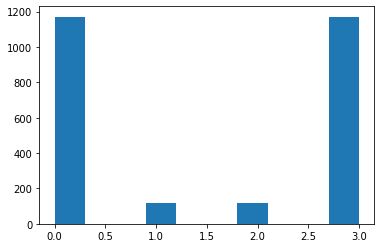

In [134]:
plt.hist(final_dataset['test']['group_ids'])

In [117]:
len([z for x,z in zip(final_dataset['test']['text'],final_dataset['test']['label']) if 'kill' in x])/len(final_dataset['test'])



0.32530290222597913

In [65]:
final_dataset.save_to_disk("/var/local/pbansal/dumps/cc_v1")

Saving the dataset (0/2 shards):   0%|          | 0/1804874 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/97320 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/97320 [00:00<?, ? examples/s]

In [138]:
f2 = datasets.DatasetDict.load_from_disk("/var/local/pbansal/dumps/cc_v3")

In [139]:
np.mean(f2['train']['label'])

0.5

In [38]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(data): 
#     print (data)
#     print (data["questions"]['text'][0])
#     return tokenizer(' [SEP] '.join(data["questions"]['text']), truncation=True)
    return tokenizer([' [SEP] '.join(x['text']) for x in data["questions"]], truncation=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)


Loading cached processed dataset at /home/pb25659/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04/cache-8cdcbac2c8955313.arrow


In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 404290
    })
})

In [40]:
np.mean([int(x) for x in tokenized_dataset['train']['is_duplicate']])

0.369197853026293

In [30]:
tokenized_dataset['train']['questions'][:10]

[{'id': [1, 2],
  'text': ['What is the step by step guide to invest in share market in india?',
   'What is the step by step guide to invest in share market?']},
 {'id': [3, 4],
  'text': ['What is the story of Kohinoor (Koh-i-Noor) Diamond?',
   'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?']},
 {'id': [5, 6],
  'text': ['How can I increase the speed of my internet connection while using a VPN?',
   'How can Internet speed be increased by hacking through DNS?']},
 {'id': [7, 8],
  'text': ['Why am I mentally very lonely? How can I solve it?',
   'Find the remainder when [math]23^{24}[/math] is divided by 24,23?']},
 {'id': [9, 10],
  'text': ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
   'Which fish would survive in salt water?']},
 {'id': [11, 12],
  'text': ['Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
   "I'm a triple Capricorn (Sun, Moon and ascendant in C

In [29]:
i = 0
(dataset['train']['instruction'][i],
dataset['train']['input'][i],
dataset['train']['output'][i],
dataset['train']['text'][i])

('Give three tips for staying healthy.',
 '',
 '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.',
 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.')

In [2]:
import torch

In [96]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = AutoModelForCausalLM.from_pretrained('facebook/opt-1.3b')
model = PeftModelForCausalLM(model, lora_config, "default")


In [6]:
lora_config = LoraConfig(
    r=1,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)

model = AutoModelForSequenceClassification.from_pretrained('facebook/opt-1.3b',num_labels=2)
model = PeftModelForSequenceClassification(model, lora_config, "default")


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
for n,p in model.base_model.model.named_parameters():
    print (n,p.requires_grad)

model.decoder.embed_tokens.weight False
model.decoder.embed_positions.weight False
model.decoder.final_layer_norm.weight False
model.decoder.final_layer_norm.bias False
model.decoder.layers.0.self_attn.k_proj.weight False
model.decoder.layers.0.self_attn.k_proj.bias False
model.decoder.layers.0.self_attn.v_proj.weight False
model.decoder.layers.0.self_attn.v_proj.bias False
model.decoder.layers.0.self_attn.v_proj.lora_A.default.weight True
model.decoder.layers.0.self_attn.v_proj.lora_B.default.weight True
model.decoder.layers.0.self_attn.q_proj.weight False
model.decoder.layers.0.self_attn.q_proj.bias False
model.decoder.layers.0.self_attn.q_proj.lora_A.default.weight True
model.decoder.layers.0.self_attn.q_proj.lora_B.default.weight True
model.decoder.layers.0.self_attn.out_proj.weight False
model.decoder.layers.0.self_attn.out_proj.bias False
model.decoder.layers.0.self_attn_layer_norm.weight False
model.decoder.layers.0.self_attn_layer_norm.bias False
model.decoder.layers.0.fc1.weig

In [82]:
for n,m in model.lm_head.named_parameters():
    print (n,m.requires_grad)

weight False


In [7]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): OPTForSequenceClassification(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50272, 2048, padding_idx=1)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 2048)
          (final_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0-23): 24 x OPTDecoderLayer(
              (self_attn): OPTAttention(
                (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
                (v_proj): Linear(
                  in_features=2048, out_features=2048, bias=True
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=2048, out_features=1, bias=False)
                  )
                  (lora_B): ModuleDict(
           

In [98]:
2048*50272

102957056